# Tower Dataset Generator in Python for Validations

this notebook implements a python-version CEM generator for the SDML-CEM tower dataset

the generator uses no optimization process as it assumes that the input CEM design parameters are either
- from the tower dataset (for validation purpose), in which the parameters have already been optimized
- or from the Text2Form machine learning engine, which should produce good enough preidcitons on the CEM parameters

note that, as the tower dataset contains no indirect deviation edge, the CEM solving process should take no more than 1 iteration

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cem_mini
from cem_mini import plot_cem_form

In [2]:
import dataset

In [3]:
import math

def _check_form(form,ax,view):
    plot_cem_form(ax,form['coords'],form['edges'],form['forces'],view=view,thickness_base=0.5,thickness_ratio=0.02)

def check_forms(forms,axis='off',view='3D-45',titles=None, title_offset=None, fname=None):
    if type(forms) is list:
        rows = int(len(forms)**0.5)
        cols = int(math.ceil(len(forms) / rows))
        
        fig=plt.figure(figsize=(16,int(16/cols*rows)))
        
        show_title=type(titles) is list
        
        for i in range(len(forms)):
            ax=fig.add_subplot(rows, cols, i+1, projection='3d')
            _check_form(forms[i],ax,view)
            plt.axis(axis)
            if show_title:
                plt.title(titles[i],y=title_offset)
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()
    elif type(forms) is dict:
        plt.figure(figsize=(8,8))
        ax=plt.axes(projection='3d')
        _check_form(forms,ax,view)
        plt.axis(axis)
        if type(titles) is str:
            plt.title(titles,y=title_offset)
            
        if fname is not None:
            plt.savefig(fname,dpi=300,bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [4]:
def to_cem_mini_topology(which):
    '''
    a validation function which generate the form of SDML-CEM dataset, using CEM input parameters from the dataset
    
    the function should produce identical form as shown in the dataset
    
    this function can later be extended as the python-version generator to validat the input parameters proposed by the Text2Form engine
    '''
    # compute trail path (i.e., connect trail edges / segments to continuous path)
    trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()
    
    # assign trail length (with positive and negative signs)
    trail_length_raw=cem_dataset.get_vector(which,'trail_length')
    trail_mag_raw=np.sign(cem_dataset.get_vector(which,'trail_mag'))
    trail_length=[[trail_length_raw[to_trail_edge_indice(i,j)] * trail_mag_raw[to_trail_edge_indice(i,j)] for j in range(len(trail_path[i])-1)] for i in range(len(trail_path))]
    
    # assign deviation force magnitudes (with positive and negative signs)
    deviation_mag=list(cem_dataset.get_vector(which,'dev_mag'))
    
    # assign initial node positions
    node_xyz=np.asarray([cem_dataset.get_vector(which,'node_x')[:16], cem_dataset.get_vector(which,'node_y')[:16], cem_dataset.get_vector(which,'node_z')[:16]]).T
    node_xyz={i:list(node_xyz[i]) for i in range(len(node_xyz))}
    
    # assign loads (uniform load on all nodes)
    load_xyz=list(cem_dataset.get_vector(which,['load_x','load_y','load_z']))
    load_xyz={i:load_xyz for i in range(cem_dataset.node_num)}

    # generate the topology using cem-mini generator
    # note that: the CEM input parameters by SDML-CEM dataset has already been optimized
    # therefore, idential form should be obtained without the need of optimization process
    T=cem_mini.create_topology(cem_dataset.node_num)
    cem_mini.set_trail_paths(T, trail_path,trail_length)
    cem_mini.set_deviation_edges(T,deviation_edge,deviation_mag)
    cem_mini.set_original_node_positions(T,node_xyz)
    cem_mini.set_node_loads(T,load_xyz)

    # solve the CEM
    F, Fc= cem_mini.CEM(T,1e-6)
    F['forces']=F['edge_forces']
    
    return F, Fc

In [5]:
import matplotlib

def draw_tolology_diagram(which, fname=None, no_color=False):
    '''
    determine the curve height by row and col number
    
    '''
    
    node_num=cem_dataset.node_num
    rows = cem_dataset.floors + 1
    cols = node_num // rows
    
    get_row = lambda x:x//cols
    get_col = lambda x:x%cols
    
    plt.close()
    plt.figure(figsize=(8,8))
    
    def draw_line(start, end, v, s='-'):
        blue_color=(0/255,110/255,180/255)
        red_color=(225/255,0/255,10/255)
        black_color=(0,0,0)
        grey_color=(0.7,0.7,0.7)
        
        xs=get_col(start)
        ys=-get_row(start)*5
        
        xe=get_col(end)
        ye=-get_row(end)*5
        
        if ys==ye:
            if abs(xs-xe)==1:
                # draw line
                plt.plot([xs,xe], [ys,ye], color = black_color if no_color else (blue_color if v<0 else red_color), linestyle=s, lw=1) 
            else:
                # draw arch
                xc=(xs+xe)/2
                w = max(xs,xe)-min(xs,xe)
                h = w*0.5+2
                
                arc = matplotlib.patches.Arc([xc,ys], w, h, 0, 180, color = black_color if no_color else (blue_color if v<0 else red_color), linestyle=s, lw=1)
                plt.gca().add_patch(arc)
        else:
            plt.plot([xs,xe], [ys,ye], color = black_color if no_color else (blue_color if v<0 else red_color), linestyle=s, lw=1) 
        
    
    # compute trail path (i.e., connect trail edges / segments to continuous path)
    trail_path, deviation_edge, to_trail_edge_indice, from_trail_edge_indice = cem_dataset.get_topology()
    
    # assign trail length (with positive and negative signs)
    trail_mag=list(cem_dataset.get_vector(which,'trail_mag'))
    deviation_mag=list(cem_dataset.get_vector(which,'dev_mag'))
    
    # plot trail edges
    for i in range(len(trail_path)):
        for j in range(len(trail_path[i])-1):
            index=to_trail_edge_indice(i,j)
            start = trail_path[i][j]
            end = trail_path[i][j+1]
            draw_line(start, end, trail_mag[index])
    
    # plot deviation edges
    for edge, v in zip(deviation_edge, deviation_mag):
        start,end=edge
        draw_line(start, end, v, '--')
    
    # plot nodes
    for r in range(rows):
        for c in range(cols):
            plt.plot(c,-r*5, 'o', color='black', markerfacecolor='orange' if r==0 else ('white' if r != (rows-1) else 'green'))
            
    plt.axis('off')
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', dpi=600)
    plt.show()

In [6]:
cem_dataset=dataset.get_dataset_from_file(r'..\cem-dataset\cem-towers\SDML_CEM.py')

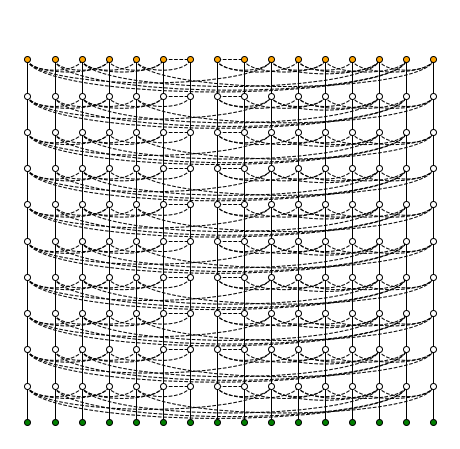

In [7]:
draw_tolology_diagram(15, '../outputs/figures/topology_diagram_template.svg',True)

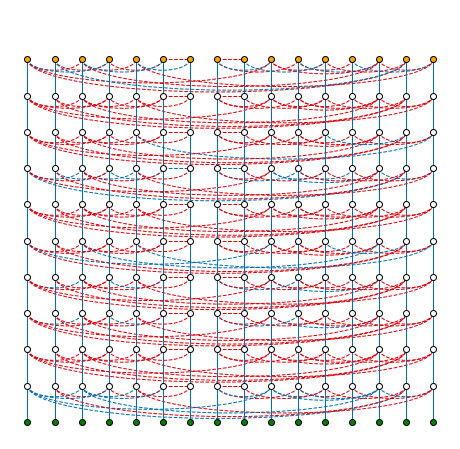

In [8]:
draw_tolology_diagram(0, '../outputs/figures/topology_diagram.svg')

In [9]:
# tunning the blud-red color for better presentation quality
cem_mini.cem_plots.blue_color=(0/255,110/255,180/255)
cem_mini.cem_plots.red_color=(225/255,0/255,10/255)
cem_mini.cem_plots.grey_color=(0.7,0.7,0.7)

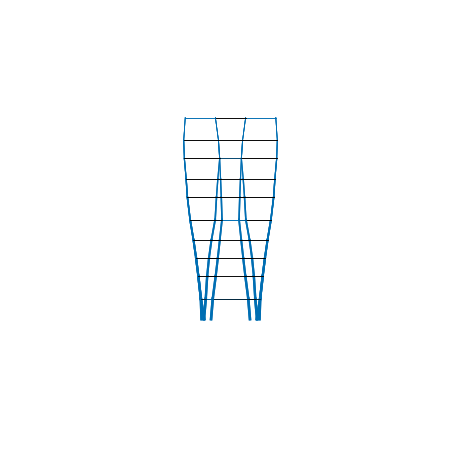

In [39]:
# 3D form

check_forms(cem_dataset.get_forms(0),view='2D-XZ')

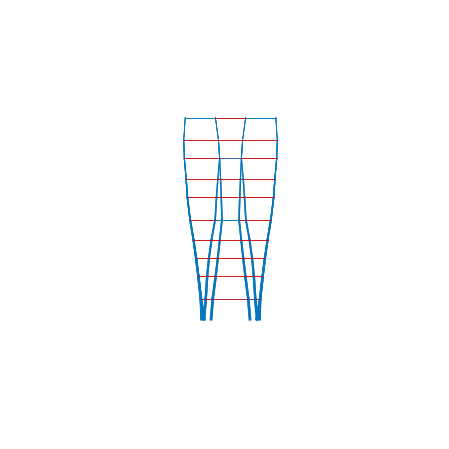

In [96]:
# 3D form generated from the design parameters

check_forms(to_cem_mini_topology(0)[0],view='2D-XZ')